<a href="https://colab.research.google.com/github/eumcloud/HHPLUS_AI/blob/main/week01/02_1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.optim import SGD, Adam
from matplotlib import pyplot as plt
import numpy as np


transform = transforms.ToTensor()
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


# CIFAR10 입력 shape 확인
print("입력 이미지 shape:", trainset[0][0].shape)


100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s]


입력 이미지 shape: torch.Size([3, 32, 32])


In [2]:

# 정확도 측정 함수
def accuracy(model, dataloader):
    cnt = 0
    acc = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)
            acc += (labels == preds).sum().item()
            cnt += labels.size(0)
    return acc / cnt

# 정확도 plot 함수
def plot_acc(acc_list1, acc_list2, label1, label2, title):
    x = np.arange(len(acc_list1))
    plt.plot(x, acc_list1, label=label1)
    plt.plot(x, acc_list2, label=label2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
class LeakyReLUModel(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)
        self.act = nn.LeakyReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)
        return x

# Sigmoid 모델 정의
class SigmoidModel(LeakyReLUModel):
    def __init__(self, input_dim, n_dim):
        super().__init__(input_dim, n_dim)
        self.act = nn.Sigmoid()

# Dropout 모델 정의
class DropoutModel(nn.Module):
    def __init__(self, input_dim, n_dim, dropout_prob=0.1):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)
        self.dropout = nn.Dropout(dropout_prob)
        self.act = nn.LeakyReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(self.act(self.layer1(x)))
        x = self.dropout(self.act(self.layer2(x)))
        x = self.layer3(x)
        return x

# 학습 함수
def train_model(model, optimizer, criterion, n_epochs=50):
    model = model.to('cuda')
    train_accs = []
    test_accs = []

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_acc = accuracy(model, trainloader)
        test_acc = accuracy(model, testloader)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Epoch {epoch:2d} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

    return train_accs, test_accs


Epoch  0 | Loss: 450.1350 | Train Acc: 0.1002 | Test Acc: 0.0998
Epoch  1 | Loss: 448.1040 | Train Acc: 0.1034 | Test Acc: 0.1042
Epoch  2 | Loss: 446.2705 | Train Acc: 0.1146 | Test Acc: 0.1147
Epoch  3 | Loss: 444.3824 | Train Acc: 0.1396 | Test Acc: 0.1431
Epoch  4 | Loss: 442.4351 | Train Acc: 0.1683 | Test Acc: 0.1734
Epoch  5 | Loss: 440.3672 | Train Acc: 0.1955 | Test Acc: 0.1988
Epoch  6 | Loss: 438.1144 | Train Acc: 0.2119 | Test Acc: 0.2127
Epoch  7 | Loss: 435.6623 | Train Acc: 0.2275 | Test Acc: 0.2244
Epoch  8 | Loss: 433.0208 | Train Acc: 0.2362 | Test Acc: 0.2322
Epoch  9 | Loss: 430.2185 | Train Acc: 0.2484 | Test Acc: 0.2459
Epoch 10 | Loss: 427.2847 | Train Acc: 0.2537 | Test Acc: 0.2505
Epoch 11 | Loss: 424.2535 | Train Acc: 0.2616 | Test Acc: 0.2568
Epoch 12 | Loss: 421.2255 | Train Acc: 0.2682 | Test Acc: 0.2637
Epoch 13 | Loss: 418.2208 | Train Acc: 0.2715 | Test Acc: 0.2708
Epoch 14 | Loss: 415.3321 | Train Acc: 0.2734 | Test Acc: 0.2725
Epoch 15 | Loss: 412.5810

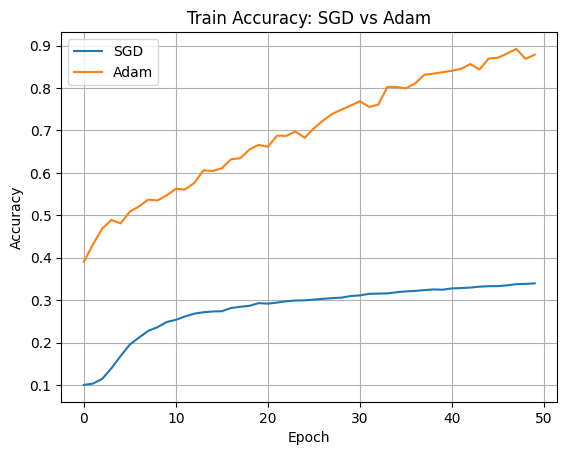

Epoch  0 | Loss: 368.8850 | Train Acc: 0.3451 | Test Acc: 0.3387
Epoch  1 | Loss: 325.2412 | Train Acc: 0.4009 | Test Acc: 0.4016
Epoch  2 | Loss: 306.2041 | Train Acc: 0.4622 | Test Acc: 0.4579
Epoch  3 | Loss: 295.3415 | Train Acc: 0.4845 | Test Acc: 0.4700
Epoch  4 | Loss: 284.9690 | Train Acc: 0.4876 | Test Acc: 0.4735
Epoch  5 | Loss: 277.4855 | Train Acc: 0.5002 | Test Acc: 0.4811
Epoch  6 | Loss: 271.3546 | Train Acc: 0.5164 | Test Acc: 0.4878
Epoch  7 | Loss: 265.2846 | Train Acc: 0.5257 | Test Acc: 0.4930
Epoch  8 | Loss: 257.9937 | Train Acc: 0.5322 | Test Acc: 0.4876
Epoch  9 | Loss: 253.8636 | Train Acc: 0.5517 | Test Acc: 0.5098
Epoch 10 | Loss: 246.4123 | Train Acc: 0.5687 | Test Acc: 0.5188
Epoch 11 | Loss: 240.4783 | Train Acc: 0.5727 | Test Acc: 0.5146
Epoch 12 | Loss: 236.3385 | Train Acc: 0.5714 | Test Acc: 0.5102
Epoch 13 | Loss: 231.8167 | Train Acc: 0.5847 | Test Acc: 0.5156
Epoch 14 | Loss: 225.9699 | Train Acc: 0.5887 | Test Acc: 0.5223
Epoch 15 | Loss: 222.0027

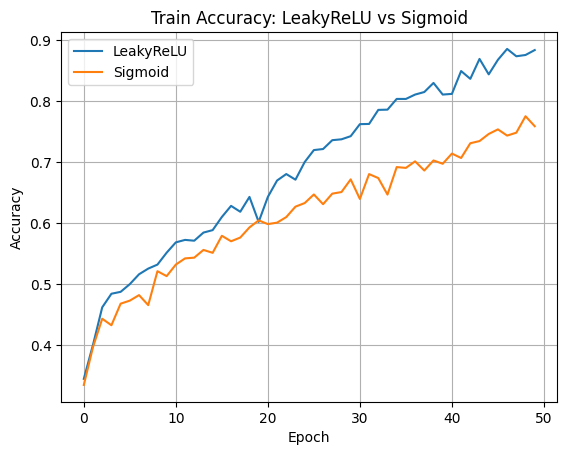

Epoch  0 | Loss: 373.0962 | Train Acc: 0.3872 | Test Acc: 0.3921
Epoch  1 | Loss: 332.1691 | Train Acc: 0.4170 | Test Acc: 0.4204
Epoch  2 | Loss: 315.1762 | Train Acc: 0.4502 | Test Acc: 0.4491
Epoch  3 | Loss: 305.1797 | Train Acc: 0.4426 | Test Acc: 0.4361
Epoch  4 | Loss: 296.8213 | Train Acc: 0.4597 | Test Acc: 0.4509
Epoch  5 | Loss: 289.4229 | Train Acc: 0.4833 | Test Acc: 0.4647
Epoch  6 | Loss: 285.5608 | Train Acc: 0.4937 | Test Acc: 0.4730
Epoch  7 | Loss: 279.3467 | Train Acc: 0.5239 | Test Acc: 0.5020
Epoch  8 | Loss: 274.9164 | Train Acc: 0.5225 | Test Acc: 0.5001
Epoch  9 | Loss: 270.4458 | Train Acc: 0.5392 | Test Acc: 0.5056
Epoch 10 | Loss: 267.3498 | Train Acc: 0.5245 | Test Acc: 0.4879
Epoch 11 | Loss: 262.8816 | Train Acc: 0.5572 | Test Acc: 0.5144
Epoch 12 | Loss: 258.3409 | Train Acc: 0.5590 | Test Acc: 0.5099
Epoch 13 | Loss: 255.2250 | Train Acc: 0.5707 | Test Acc: 0.5244
Epoch 14 | Loss: 251.8207 | Train Acc: 0.5667 | Test Acc: 0.5152
Epoch 15 | Loss: 248.4291

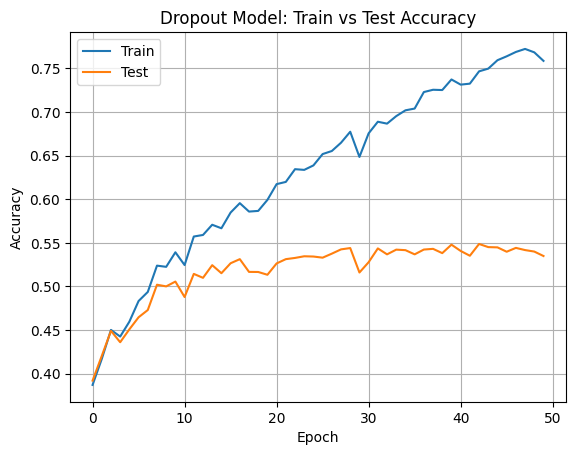

In [4]:
# 1. SGD vs Adam (LeakyReLU 사용)
model_sgd = LeakyReLUModel(3 * 32 * 32, 1024)
model_adam = LeakyReLUModel(3 * 32 * 32, 1024)

acc_sgd, _ = train_model(model_sgd, SGD(model_sgd.parameters(), lr=0.001), nn.CrossEntropyLoss())
acc_adam, _ = train_model(model_adam, Adam(model_adam.parameters(), lr=0.001), nn.CrossEntropyLoss())
plot_acc(acc_sgd, acc_adam, "SGD", "Adam", "Train Accuracy: SGD vs Adam")

# 2. LeakyReLU vs Sigmoid (둘 다 Adam 사용)
model_relu = LeakyReLUModel(3 * 32 * 32, 1024)
model_sigmoid = SigmoidModel(3 * 32 * 32, 1024)

acc_relu, _ = train_model(model_relu, Adam(model_relu.parameters(), lr=0.001), nn.CrossEntropyLoss())
acc_sigmoid, _ = train_model(model_sigmoid, Adam(model_sigmoid.parameters(), lr=0.001), nn.CrossEntropyLoss())
plot_acc(acc_relu, acc_sigmoid, "LeakyReLU", "Sigmoid", "Train Accuracy: LeakyReLU vs Sigmoid")

# 3. Dropout 모델 (Adam 사용) - Train/Test Accuracy 비교
model_dropout = DropoutModel(3 * 32 * 32, 1024)
acc_train_dropout, acc_test_dropout = train_model(model_dropout, Adam(model_dropout.parameters(), lr=0.001), nn.CrossEntropyLoss())
plot_acc(acc_train_dropout, acc_test_dropout, "Train", "Test", "Dropout Model: Train vs Test Accuracy")

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
n_epochs = 50
batch_size = 256

# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Using device: cuda


Training Base Model:
Epoch 1, Loss: 1.6407, Train Accuracy: 0.4986, Test Accuracy: 0.4783
Epoch 2, Loss: 1.4163, Train Accuracy: 0.5462, Test Accuracy: 0.5046
Epoch 3, Loss: 1.2941, Train Accuracy: 0.5882, Test Accuracy: 0.5225
Epoch 4, Loss: 1.1953, Train Accuracy: 0.6208, Test Accuracy: 0.5340
Epoch 5, Loss: 1.1084, Train Accuracy: 0.6587, Test Accuracy: 0.5400
Epoch 6, Loss: 1.0240, Train Accuracy: 0.6687, Test Accuracy: 0.5318
Epoch 7, Loss: 0.9416, Train Accuracy: 0.7062, Test Accuracy: 0.5396
Epoch 8, Loss: 0.8675, Train Accuracy: 0.7484, Test Accuracy: 0.5560
Epoch 9, Loss: 0.7845, Train Accuracy: 0.7621, Test Accuracy: 0.5404
Epoch 10, Loss: 0.7063, Train Accuracy: 0.7929, Test Accuracy: 0.5436
Epoch 11, Loss: 0.6454, Train Accuracy: 0.8125, Test Accuracy: 0.5450
Epoch 12, Loss: 0.5754, Train Accuracy: 0.8215, Test Accuracy: 0.5337
Epoch 13, Loss: 0.5184, Train Accuracy: 0.8585, Test Accuracy: 0.5431
Epoch 14, Loss: 0.4534, Train Accuracy: 0.8773, Test Accuracy: 0.5401
Epoch 15

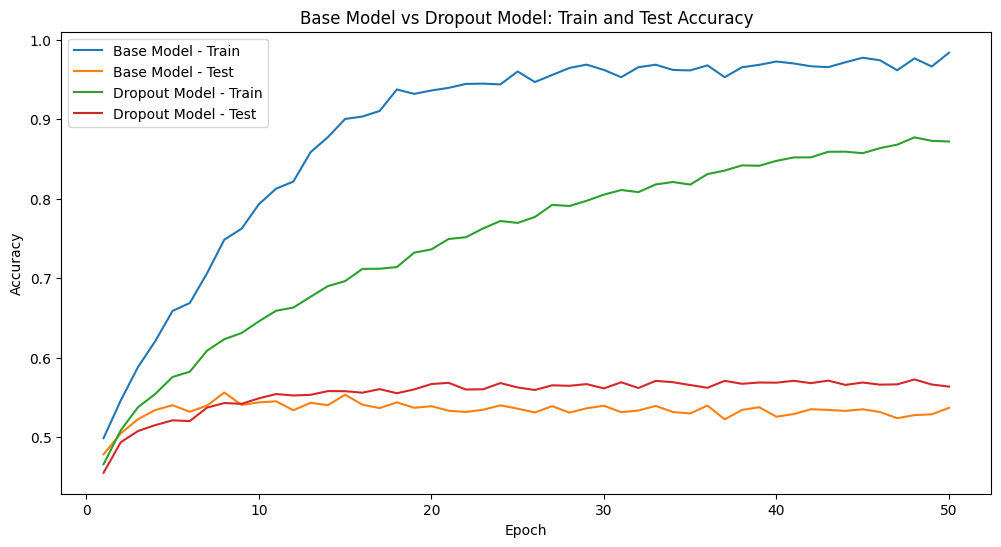

Base Model - Final Train Accuracy: 0.9836, Test Accuracy: 0.5367
Dropout Model - Final Train Accuracy: 0.8719, Test Accuracy: 0.5635


In [6]:
# Define models
class BaseModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.act = nn.LeakyReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

class DropoutModel(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(self.act(self.fc1(x)))
        x = self.dropout(self.act(self.fc2(x)))
        x = self.fc3(x)
        return x

# Accuracy calculation function
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval() # Ensure model is in evaluation mode
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training function
def train_model(model, optimizer, criterion, train_loader, test_loader, epochs):
    train_acc_history = []
    test_acc_history = []

    for epoch in range(epochs):
        model.train() # Ensure model is in training mode
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_acc = calculate_accuracy(model, train_loader)
        test_acc = calculate_accuracy(model, test_loader)
        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

    return train_acc_history, test_acc_history

# Initialize models
input_dim = 32 * 32 * 3 # CIFAR10 image size
base_model = BaseModel(input_dim).to(device)
dropout_model = DropoutModel(input_dim).to(device)

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
base_optimizer = optim.Adam(base_model.parameters(), lr=0.001)
dropout_optimizer = optim.Adam(dropout_model.parameters(), lr=0.001)

# Train models
print("Training Base Model:")
base_train_acc, base_test_acc = train_model(base_model, base_optimizer, criterion, trainloader, testloader, n_epochs)

print("\nTraining Dropout Model:")
dropout_train_acc, dropout_test_acc = train_model(dropout_model, dropout_optimizer, criterion, trainloader, testloader, n_epochs)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(range(1, n_epochs+1), base_train_acc, label='Base Model - Train')
plt.plot(range(1, n_epochs+1), base_test_acc, label='Base Model - Test')
plt.plot(range(1, n_epochs+1), dropout_train_acc, label='Dropout Model - Train')
plt.plot(range(1, n_epochs+1), dropout_test_acc, label='Dropout Model - Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Base Model vs Dropout Model: Train and Test Accuracy')
plt.legend()
plt.show()

# Print final accuracies
print(f"Base Model - Final Train Accuracy: {base_train_acc[-1]:.4f}, Test Accuracy: {base_test_acc[-1]:.4f}")
print(f"Dropout Model - Final Train Accuracy: {dropout_train_acc[-1]:.4f}, Test Accuracy: {dropout_test_acc[-1]:.4f}")